
==== SYMMETRY STRESS TEST REPORT ====
seed = 7
Nreal = 200
sigma_dn = 2.00e-06
------------------------------------
ε_sym (reference, no disorder) = 3.593e-03
⟨ε_sym⟩ (single-shot mean)     = 1.308
ε_sym (ensemble mean)          = 1.240e-01
------------------------------------
⟨δn⟩ (mean over realizations)  = -7.445e-25
parity bias of δn (mean)       = 2.226e-06


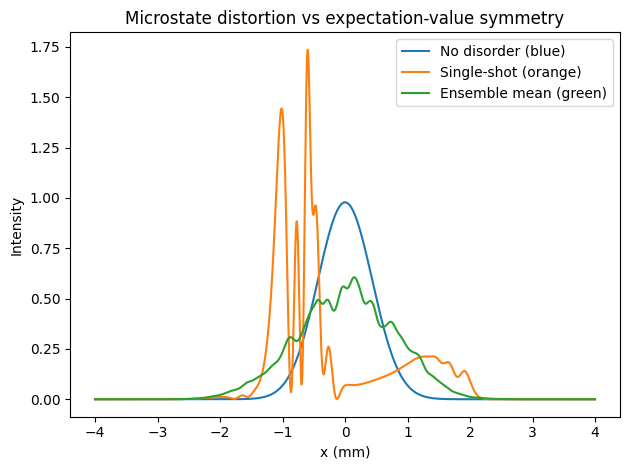

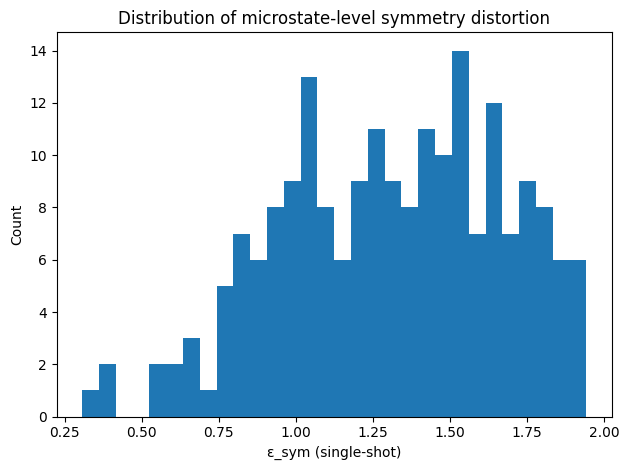

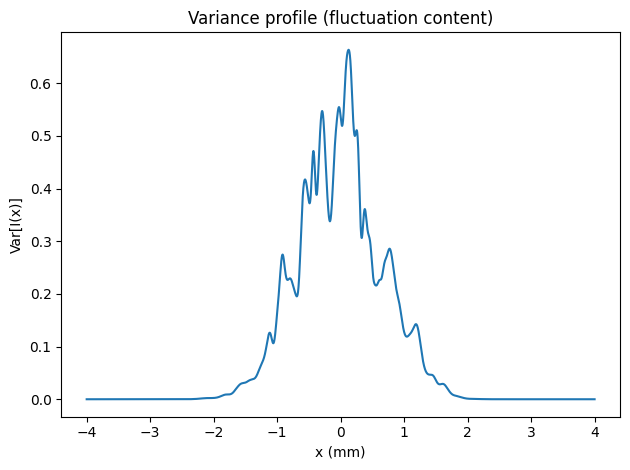

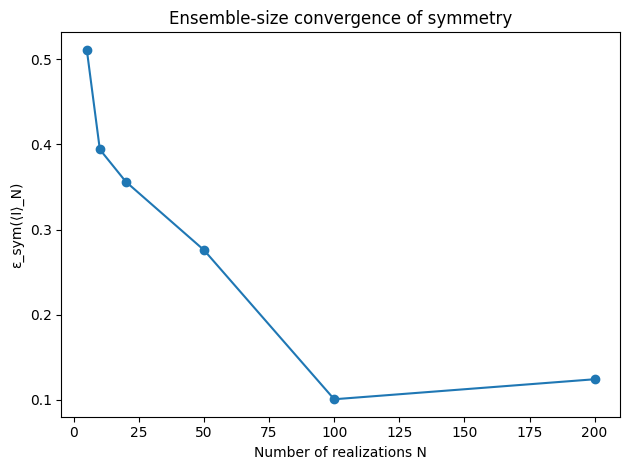


==== SYMMETRY STRESS TEST REPORT ====
seed = 7
Nreal = 200
sigma_dn = 0.00e+00
------------------------------------
ε_sym (reference, no disorder) = 3.593e-03
⟨ε_sym⟩ (single-shot mean)     = 0.004
ε_sym (ensemble mean)          = 3.593e-03
------------------------------------
⟨δn⟩ (mean over realizations)  = 0.000e+00
parity bias of δn (mean)       = 0.000e+00

==== SYMMETRY STRESS TEST REPORT ====
seed = 7
Nreal = 200
sigma_dn = 5.00e-07
------------------------------------
ε_sym (reference, no disorder) = 3.593e-03
⟨ε_sym⟩ (single-shot mean)     = 0.958
ε_sym (ensemble mean)          = 5.768e-02
------------------------------------
⟨δn⟩ (mean over realizations)  = -1.861e-25
parity bias of δn (mean)       = 5.565e-07

==== SYMMETRY STRESS TEST REPORT ====
seed = 7
Nreal = 200
sigma_dn = 1.00e-06
------------------------------------
ε_sym (reference, no disorder) = 3.593e-03
⟨ε_sym⟩ (single-shot mean)     = 1.188
ε_sym (ensemble mean)          = 9.139e-02
---------------------------

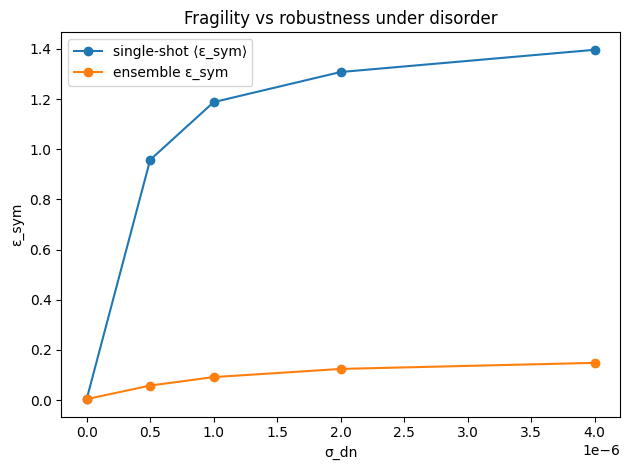

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Core physics utilities
# ============================================================

def gaussian_packet(x, x0=0.0, w0=0.6e-3, kx0=0.0):
    return np.exp(-(x-x0)**2/(2*w0**2)) * np.exp(1j*kx0*x)

def correlated_noise_1d(n, dx, corr_len, rng):
    k = 2*np.pi*np.fft.fftfreq(n, d=dx)
    w = rng.normal(size=n) + 1j*rng.normal(size=n)
    filt = np.exp(-0.5*(k*corr_len)**2)
    dn = np.fft.ifft(w*filt).real
    dn -= dn.mean()
    dn /= dn.std()
    return dn

def split_step(E0, x, dz, nsteps, k0, delta_n):
    dx = x[1]-x[0]
    k = 2*np.pi*np.fft.fftfreq(len(x), d=dx)

    V = k0*delta_n
    expV = np.exp(-1j*V*dz/2)
    expD = np.exp(-1j*(k**2)*dz/(2*k0))

    E = E0.copy().astype(np.complex128)
    for _ in range(nsteps):
        E = expV*E
        Ek = np.fft.fft(E)
        Ek *= expD
        E = np.fft.ifft(Ek)
        E = expV*E
    return E

def parity_asymmetry(I):
    return np.sum(np.abs(I - I[::-1])) / (np.sum(I)+1e-15)

# ============================================================
# Main stress test
# ============================================================

def run_stress_test(
    seed=7,
    Nreal=200,
    lam=800e-9,
    Lx=8e-3,
    Nx=4096,
    z_total=0.6,
    dz=2e-3,
    corr_len=0.25e-3,
    sigma_dn=2e-6,
    w0=0.6e-3,
    do_plots=True
):
    rng = np.random.default_rng(seed)
    x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
    k0 = 2*np.pi/lam
    nsteps = int(z_total/dz)

    # --------------------------------------------------------
    # Reference (blue): no disorder
    # --------------------------------------------------------
    E0 = gaussian_packet(x, w0=w0)
    E_ref = split_step(E0, x, dz, nsteps, k0, np.zeros_like(x))
    I_ref = np.abs(E_ref)**2
    eps_ref = parity_asymmetry(I_ref)

    # --------------------------------------------------------
    # Disorder ensemble (orange → green)
    # --------------------------------------------------------
    I_all = np.zeros((Nreal, Nx))
    eps_single = []

    dn_means = []
    dn_parity = []

    for r in range(Nreal):
        dn_raw = correlated_noise_1d(Nx, x[1]-x[0], corr_len, rng)
        delta_n = sigma_dn * dn_raw

        # disorder sanity checks
        dn_means.append(delta_n.mean())
        dn_parity.append(np.mean(np.abs(delta_n - delta_n[::-1])))

        E = split_step(E0, x, dz, nsteps, k0, delta_n)
        I = np.abs(E)**2
        I_all[r] = I
        eps_single.append(parity_asymmetry(I))

    I_mean = I_all.mean(axis=0)
    eps_ens = parity_asymmetry(I_mean)

    # --------------------------------------------------------
    # Ensemble-size convergence
    # --------------------------------------------------------
    Ns = np.array([5, 10, 20, 50, 100, Nreal])
    eps_conv = []
    for N in Ns:
        eps_conv.append(parity_asymmetry(I_all[:N].mean(axis=0)))

    # --------------------------------------------------------
    # Variance profile
    # --------------------------------------------------------
    I_var = I_all.var(axis=0)

    # --------------------------------------------------------
    # Reporting
    # --------------------------------------------------------
    print("\n==== SYMMETRY STRESS TEST REPORT ====")
    print(f"seed = {seed}")
    print(f"Nreal = {Nreal}")
    print(f"sigma_dn = {sigma_dn:.2e}")
    print("------------------------------------")
    print(f"ε_sym (reference, no disorder) = {eps_ref:.3e}")
    print(f"⟨ε_sym⟩ (single-shot mean)     = {np.mean(eps_single):.3f}")
    print(f"ε_sym (ensemble mean)          = {eps_ens:.3e}")
    print("------------------------------------")
    print(f"⟨δn⟩ (mean over realizations)  = {np.mean(dn_means):.3e}")
    print(f"parity bias of δn (mean)       = {np.mean(dn_parity):.3e}")

    # --------------------------------------------------------
    # Plots
    # --------------------------------------------------------
    if do_plots:
        # Blue / Orange / Green
        idx = np.argsort(eps_single)[len(eps_single)//2]
        plt.figure()
        plt.plot(x*1e3, I_ref, label="No disorder (blue)")
        plt.plot(x*1e3, I_all[idx], label="Single-shot (orange)")
        plt.plot(x*1e3, I_mean, label="Ensemble mean (green)")
        plt.xlabel("x (mm)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.title("Microstate distortion vs expectation-value symmetry")
        plt.tight_layout()

        # Histogram
        plt.figure()
        plt.hist(eps_single, bins=30)
        plt.xlabel("ε_sym (single-shot)")
        plt.ylabel("Count")
        plt.title("Distribution of microstate-level symmetry distortion")
        plt.tight_layout()

        # Variance
        plt.figure()
        plt.plot(x*1e3, I_var)
        plt.xlabel("x (mm)")
        plt.ylabel("Var[I(x)]")
        plt.title("Variance profile (fluctuation content)")
        plt.tight_layout()

        # Convergence
        plt.figure()
        plt.plot(Ns, eps_conv, marker='o')
        plt.xlabel("Number of realizations N")
        plt.ylabel("ε_sym(⟨I⟩_N)")
        plt.title("Ensemble-size convergence of symmetry")
        plt.tight_layout()

        plt.show()

    return {
        "eps_ref": eps_ref,
        "eps_single_mean": float(np.mean(eps_single)),
        "eps_ens": eps_ens,
        "eps_conv": (Ns, eps_conv)
    }

# ============================================================
# Optional disorder-strength sweep
# ============================================================

def disorder_strength_sweep(sigmas, seed=7):
    eps_single = []
    eps_ens = []

    for s in sigmas:
        m = run_stress_test(seed=seed, sigma_dn=s, do_plots=False)
        eps_single.append(m["eps_single_mean"])
        eps_ens.append(m["eps_ens"])

    plt.figure()
    plt.plot(sigmas, eps_single, 'o-', label="single-shot ⟨ε_sym⟩")
    plt.plot(sigmas, eps_ens, 'o-', label="ensemble ε_sym")
    plt.xlabel("σ_dn")
    plt.ylabel("ε_sym")
    plt.legend()
    plt.title("Fragility vs robustness under disorder")
    plt.tight_layout()
    plt.show()

# ============================================================
# Run
# ============================================================

if __name__ == "__main__":
    run_stress_test()
    disorder_strength_sweep([0, 0.5e-6, 1e-6, 2e-6, 4e-6])
